# Summary of Progress in Searching for Orbital Parameters ($K,\,e,\,\omega,\,T,\,P,\,\gamma$) from Radial Velocities


## Finding a mass ratio and constraining the period.


First, after the import and definition of a few packages, functions, and variables, the mass ratio is found. Periodograms and data windows are then calculated, and plots are created to aid in interpretation. DQ Tau is a 'well behaved' system with many visits, and shows a clear peak at a period of about 15.8 days, even after the subtraction of the values of the data window. The data appear periodic when phased to this period, and the mass ratio appears fairly well defined.

mass ratio is  0.898896068135 +/- 0.0542443564974
Periodogram peaks above a power of 0.25: [ 15.80455526]


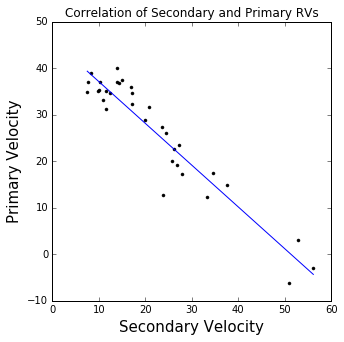

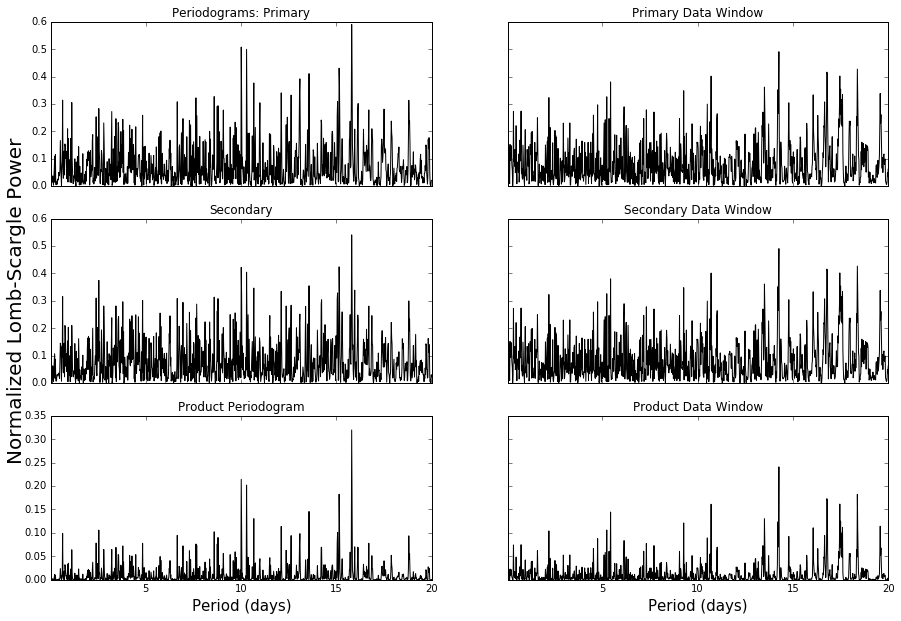

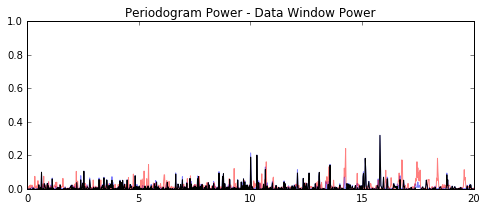

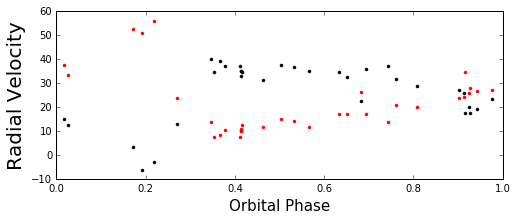

In [11]:
#import-libraries-and-data---------------------------------------------------------------------------------------#
import time
import emcee
import corner
import numpy as np
import functions as f
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
filename     = 'Systems/DQ Tau/DQ Tau.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))

#define-variables------------------------------------------------------------------------------------------------#

JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD
samples      = 1000
max_period   = 20
power_cutoff = 0.25
ndim, nwalkers, nsteps = 6, 400, 10000

#define-functions------------------------------------------------------------------------------------------------#

periodogram    = f.periodogram
dataWindow     = f.dataWindow
maxima         = f.maxima
phases         = f.phases
massRatio      = f.massRatio
adjustment     = f.adjustment
RV             = f.RV
alteredRV      = f.alteredRV
residuals      = f.residuals
constraints    = f.constraints
initialGuess   = f.initialGuess
initialGuessNoE= f.initialGuessNoE



#now-do-things!--------------------------------------------------------------------------------------------------#

#Secondary v Primary plot (mass ratio)
mass_ratio, intercept, r_squared, standard_error, slope_error = massRatio(RVs,RVp, system)
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(RVs, RVp, 'k.')
ax.set_title('Correlation of Secondary and Primary RVs')
x, y = np.array([np.nanmin(RVs), np.nanmax(RVs)]),-mass_ratio*np.array([np.nanmin(RVs), 
                                                                        np.nanmax(RVs)])+intercept
ax.plot(x, y)
ax.set_ylabel('Primary Velocity', size='15')
ax.set_xlabel('Secondary Velocity', size='15')
print('mass ratio is ', mass_ratio, "+/-", standard_error)

#screen for invalid values
JDp, RVp = adjustment(JD, RVp)
JDs, RVs = adjustment(JD, RVs)

#calculate periodograms
x, y  = periodogram(JDp, RVp, samples, max_period)
y2    = periodogram(JDs, RVs, samples, max_period)[1]
y3,y4 = dataWindow(JDp, samples, max_period)[1], dataWindow(JDs, samples, max_period)[1]

#plot periodograms
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex='col', sharey='row')
ax1.plot(x, y, 'k')
ax1.set_title('Periodograms: Primary')
ax1.set_xlim(1/24, max_period)
ax4.set_xlim(1/24, max_period)
ax2.plot(x, y2, 'k')
ax2.set_title('Secondary')
ax3.plot(x, y*y2, 'k')
ax3.set_title('Product Periodogram')
ax4.plot(x, y3, 'k')
ax4.set_title('Primary Data Window')
ax5.plot(x, y4, 'k')
ax5.set_title('Secondary Data Window')
ax6.plot(x, y3*y4, 'k')
ax6.set_title('Product Data Window')
ax3.set_xlabel('Period (days)', size='15')
ax6.set_xlabel('Period (days)', size='15')
ax2.set_ylabel('Normalized Lomb-Scargle Power', size='20')
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.savefig(filename + ' periodogram.pdf')
print('Periodogram peaks above a power of 0.25:', maxima(power_cutoff, x, y, y2))

#plot periodogram - data window
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot(x, y*y2, 'b', alpha = 0.5)
ax.plot(x, y3*y4, 'r', alpha = 0.5)
ax.plot(x, y*y2-y3*y4, 'k', alpha = 1)
ax.set_ylim(0,1)
ax.set_title('Periodogram Power - Data Window Power')

#plot phased RVs
fig = plt.figure(figsize=(8,3))
ax = plt.subplot(111)
ax.plot(phases(maxima(power_cutoff, x, y, y2)[0], JDp), RVp, 'k.')
ax.plot(phases(maxima(power_cutoff, x, y, y2)[0], JDs), RVs, 'r.')
ax.set_title('')
ax.set_xlabel('Orbital Phase', size='15')
ax.set_ylabel('Radial Velocity', size='20')
#plt.savefig(filename + ' RV-phase diagram.pdf')

## Taking a walk with a markov chain, getting results


Based on the plot above of data phased to our guess of the period, the parameters $\,K,\,P,$ and $\gamma$ are constrained to reasonable values, scipy's curve_fit() quickly finds an initial guess of the parameters, and these results are fed into the emcee ensemble sample, which takes over.

A corner plot shows the walker locations in various cross sections of the parameter space over over the entire walk, along with the results with uncertainties, and result histograms. Note that the period is not found to be 0, it is just smaller than the two decimal places shown. The second plot created shows the locations of the walkers over the entire walk, a red line for the initial guess of the parameter's value, and a blue line for the result found. Note that the walkers are intsantiated in a gaussian around the initial guess, and converge toward some result; when reporting final values one should truncate the beginning of the chain so only the converged walker steps are used in determining the results (in this case maybe the first 2000 steps, this varies between systems and with the arguments used in the MCMC).

The third plot shows a set of RV curves for the system using the result parameters, and the data phased to the result period. In this case we have a not obviously wrong set of results!

/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


Completed in  8  minutes and  3 seconds.


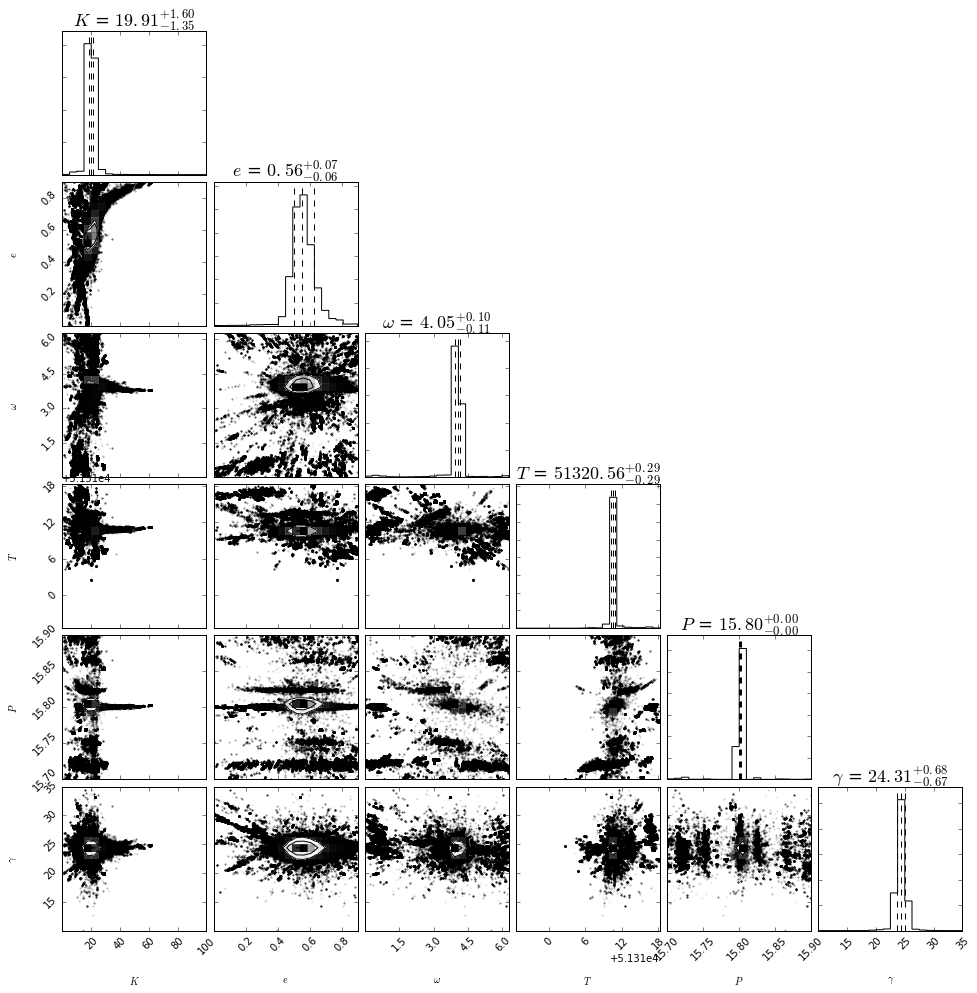

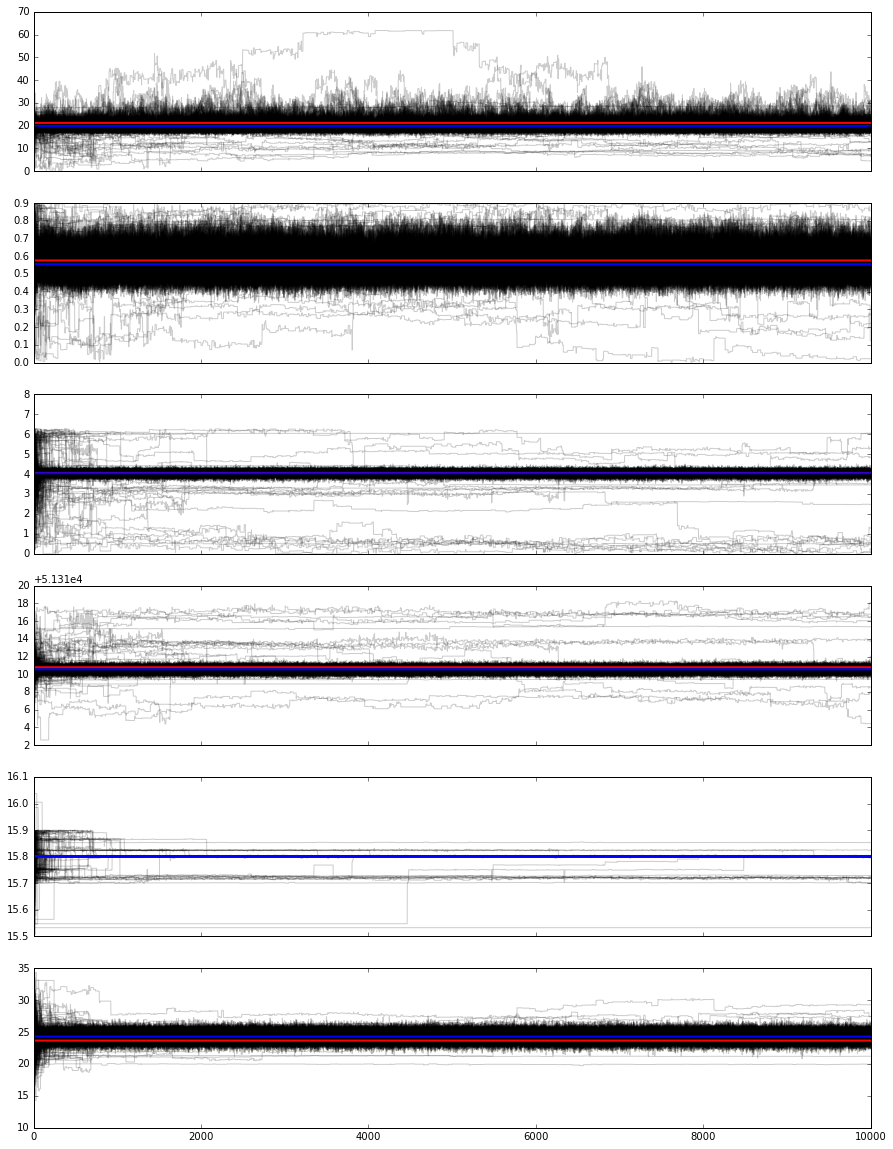

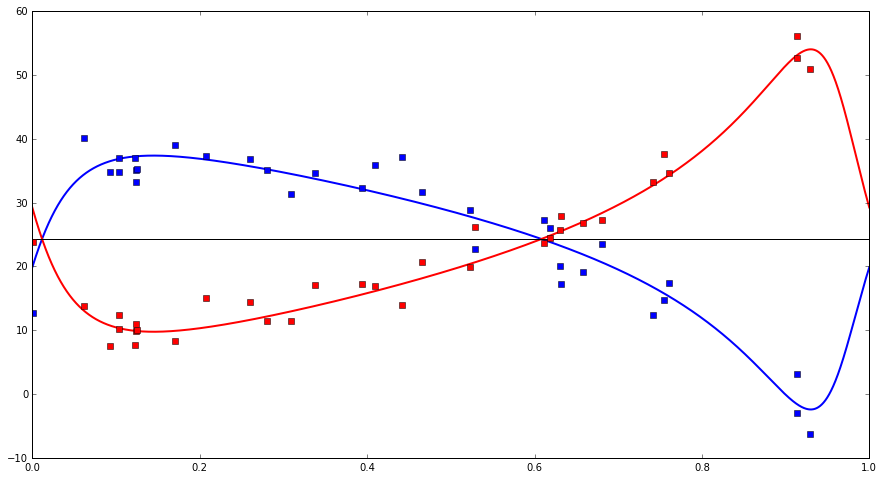

In [12]:
t0 = time.time()

#constrain parameters
lower_bounds = [0, 0, 0, JD[0]+((JD[-1]-JD[0])/2)-0.75*15.8, 15.7, 10]
upper_bounds = [100, 0.9, 2*np.pi, JD[0]+((JD[-1]-JD[0])/2)+0.75*15.8, 15.9, 35]

initial_guess = initialGuess(lower_bounds, upper_bounds, JDp, RVp)

def likelihood(parameters, mass_ratio, primary, secondary):
    r = np.sqrt(sum((np.asarray(primary)-RV(JDp, mass_ratio, parameters)[0])**2)
        +sum((np.asarray(secondary)-RV(JDs, mass_ratio, parameters)[1])**2))
    return -r

#function is poorly named, returns the negative infinity if parameters lie outside contraints, otherwise
#returns the output from residuals()
def probability(initial_guess, mass_ratio, RVp, RVs, lower, upper):
    con = constraints(initial_guess, lower, upper)
    if not np.isfinite(con):
        return -np.inf
    return con + likelihood(initial_guess, mass_ratio, RVp, RVs)



#initialize walkers 
position = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

#walkers distributed in gaussian ball around most likely parameter values
for i in range(0, nwalkers-1):
    position[i][0] = initial_guess[0] + 2.5*np.random.randn(1) #K
    position[i][1] = initial_guess[1] + 0.1*np.random.randn(1) #e
    position[i][2] = initial_guess[2] + 1  *np.random.randn(1) #w
    position[i][3] = initial_guess[3] +     np.random.randn(1) #T
    position[i][4] = initial_guess[4] + 0.1*np.random.randn(1) #P
    position[i][5] = initial_guess[5] + 3  *np.random.randn(1) #y

#create the sampler object and take a walk
sampler = emcee.EnsembleSampler(nwalkers, ndim, probability,
                                args=(mass_ratio, RVp, RVs, lower_bounds, upper_bounds), threads = 4)
sampler.run_mcmc(position, nsteps)

#save the results of the walk
samples = sampler.chain[:, :, :].reshape((-1, ndim))
results = np.asarray(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samples, [16, 50, 84], axis=0)))))

#create the corner plot
fig = corner.corner(samples, labels=["$K$", "$e$", "$\omega$", "$T$", "$P$", "$\gamma$"],
                    extents=[[lower_bounds[0], upper_bounds[0]], [lower_bounds[1],upper_bounds[1]],
                             [lower_bounds[2], upper_bounds[2]],
                             [lower_bounds[3], upper_bounds[3]], [lower_bounds[4], upper_bounds[4]],
                             [lower_bounds[5], upper_bounds[5]]],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})
#fig.savefig("parameter_results.png")

#create the walkers plot
fig, ax = plt.subplots(ndim, 1, sharex='col')
for i in range(ndim):
    for j in range(len(sampler.chain[:, 0, i])):
        ax[i].plot(np.linspace(0, nsteps, num=nsteps), sampler.chain[j, :, i], 'k', alpha=0.2)
    ax[i].plot(np.linspace(0, nsteps, num=nsteps) , np.ones(nsteps)*initial_guess[i], 'r', lw=2)
    ax[i].plot(np.linspace(0, nsteps, num=nsteps) , np.ones(nsteps)*results[i][0], 'b', lw=2)
fig.set_figheight(20)
fig.set_figwidth(15)
#plt.savefig('walk_results.png')

#create the curves plot
x = np.linspace(0, 15.8, num=nsteps)
fig, ax = plt.figure(figsize=(15,8)), plt.subplot(111)
#commented out section shows a sampling of curves from the walk
#for K, e, w, T, P, y in samples[np.random.randint(len(samples), size=250)]:
#    parameters = K, e, w, T, P, y
#    primary, secondary = RV(x, mass_ratio, parameters)
#    ax.plot(x/parameters[4], primary, 'c', label='Potential Primary Curves', alpha=0.2)
#    ax.plot(x/parameters[4], secondary, 'm', label='Potential Secondary Curves', alpha=0.2)
primary, secondary = RV(x, mass_ratio, [results[0][0], results[1][0], results[2][0],
                                        results[3][0], results[4][0], results[5][0]])
ax.plot(x/results[4][0], primary, 'b', lw=2)
ax.plot(x/results[4][0], secondary, 'r', lw=2)
ax.plot(x, np.ones(len(x))*results[5][0], 'k' , label='Systemic Velocity')
ax.plot(phases(results[4][0], JDp), RVp, 'bs', label='Primary RV Data') #data phased to result period
ax.plot(phases(results[4][0], JDs), RVs, 'rs', label='Secondary RV data')
ax.set_xlim([0,1])
#plt.savefig('curve_results.png')

t = time.time()
print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')

## For a non-eccentric system...


If $e$ is sufficiently low (usually < 0.1), $\omega$ and $T$ become a degenerate pair, i.e. every value of $\omega$ has a corresponding value of $T$ which results in a good fit. This becomes apparent in the parameter histograms of the corner plot, and the walker plot. The walkers search the entire range allowed with no preference toward a particular value.

This is bad.

For those cases I've written a fitter which fits curves for an assumed-to-be circualr orbit. The output is essentially identical to the cell above, but with only four parameters, $K,\,T,\,P,\,\gamma$. As shown by the plots, it's obviously not a good fit for this system.

/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/skinnej3/anaconda/lib/python3.5/site-packages/emcee-2.1.0-py3.5.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


Completed in  2  minutes and  52 seconds.


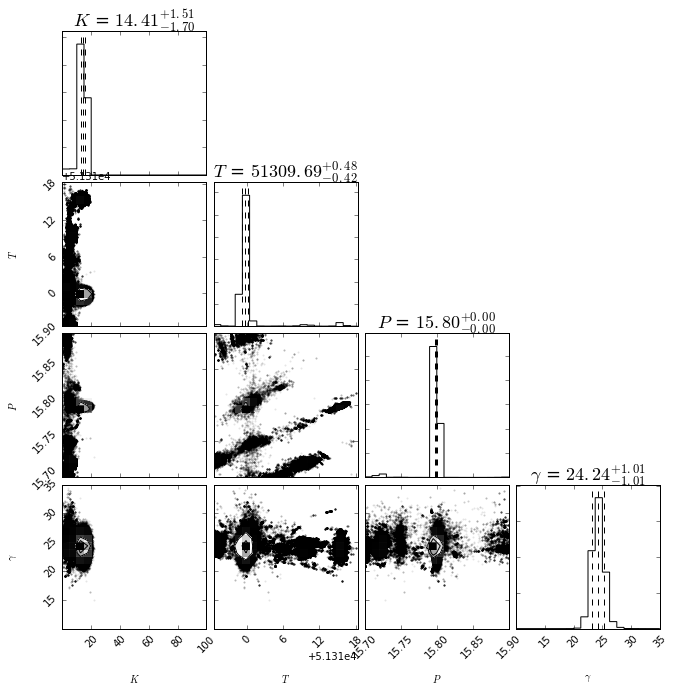

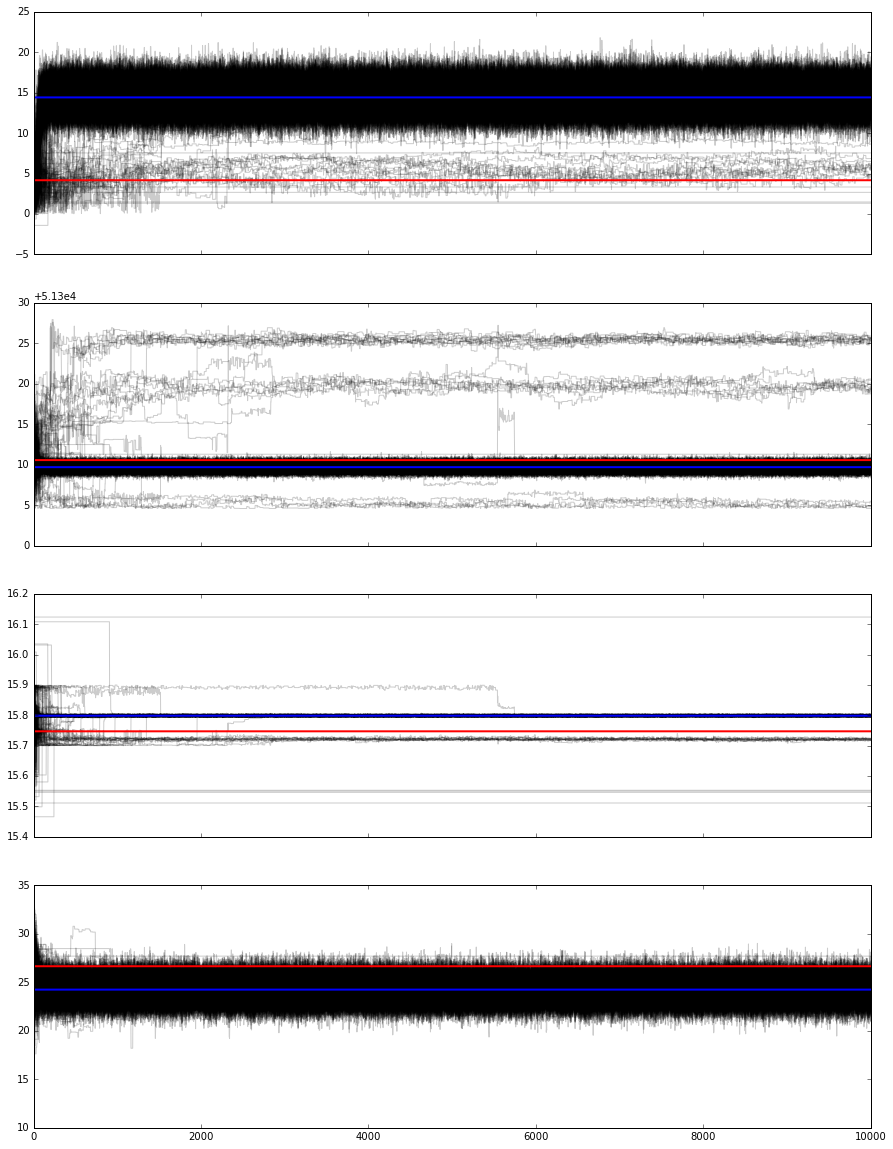

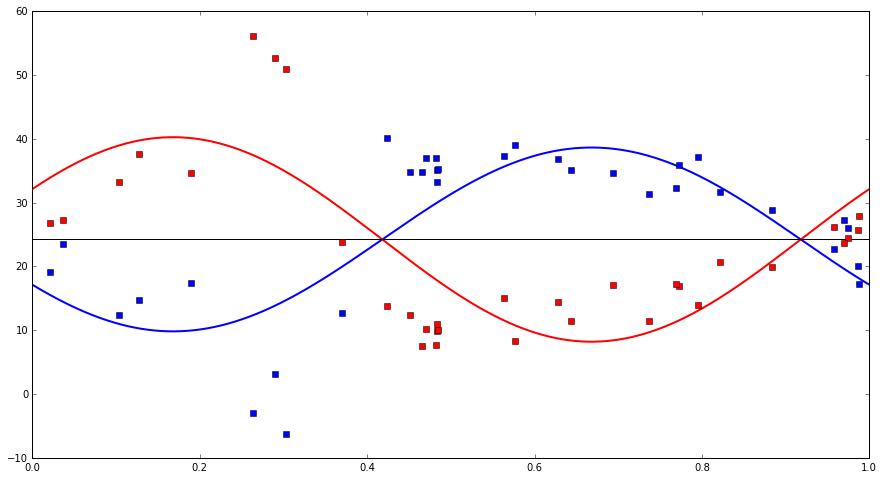

In [13]:
#no e MCMC
t0 = time.time()

#adjustments for a circular fit
ndim = 4
del lower_bounds[1:3], upper_bounds[1:3]

initial_guess = initialGuessNoE(lower_bounds, upper_bounds, JDp, RVp)

def likelihood(parameters, mass_ratio, primary, secondary):
    r = np.sqrt(sum((np.asarray(primary)-RV(JDp, mass_ratio, parameters)[0])**2)
        +sum((np.asarray(secondary)-RV(JDs, mass_ratio, parameters)[1])**2))
    return -r

#function is poorly named, returns the negative infinity if parameters lie outside contraints, otherwise
#returns the output from residuals()
def probability(initial_guess, mass_ratio, RVp, RVs, lower, upper):
    con = constraints(initial_guess, lower, upper)
    if not np.isfinite(con):
        return -np.inf
    return con + likelihood(initial_guess, mass_ratio, RVp, RVs)

#initialize walkers 
position = [initial_guess + 0.1*np.random.randn(ndim) for i in range(nwalkers)]

#walkers distributed in gaussian ball around most likely parameter values
for i in range(nwalkers):
    position[i][0] = initial_guess[0] + 2.5*np.random.randn(1) #K
    position[i][1] = initial_guess[1] +     np.random.randn(1) #T
    position[i][2] = initial_guess[2] + 0.1*np.random.randn(1) #P
    position[i][3] = initial_guess[3] + 3  *np.random.randn(1) #y

#create the sampler object and do the walk
sampler = emcee.EnsembleSampler(nwalkers, ndim, probability,
                                args=(mass_ratio, RVp, RVs, lower_bounds, upper_bounds), threads = 4)
sampler.run_mcmc(position, nsteps)

#save the results of the walk

samples = sampler.chain[:, :, :].reshape((-1, ndim))

results = np.asarray(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                              zip(*np.percentile(samples, [16, 50, 84], axis=0)))))

#create the corner plot
fig = corner.corner(samples, labels=["$K$", "$T$", "$P$", "$\gamma$"],
                    extents=[[lower_bounds[0], upper_bounds[0]], [lower_bounds[1],upper_bounds[1]],
                             [lower_bounds[2], upper_bounds[2]], [lower_bounds[3], upper_bounds[3]]],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 18})
#plt.savefig('parameter_results.png')

#create the walkers plot
fig, ax = plt.subplots(ndim, 1, sharex='col')
for i in range(ndim):
    for j in range(len(sampler.chain[:, 0, i])):
        ax[i].plot(np.linspace(0, nsteps, num=nsteps), sampler.chain[j, :, i], 'k', alpha=0.2)
    ax[i].plot(np.linspace(0, nsteps, num=nsteps) , np.ones(nsteps)*initial_guess[i], 'r', lw=2)
    ax[i].plot(np.linspace(0, nsteps, num=nsteps) , np.ones(nsteps)*results[i][0], 'b', lw=2)
fig.set_figheight(20)
fig.set_figwidth(15)
#plt.savefig('walk_results.png')

#create the curves plot
x = np.linspace(0, 15.8, num=nsteps)
fig, ax = plt.figure(figsize=(15,8)), plt.subplot(111)
#commented out section shows a sampling of curves from the walk
#for K, e, w, T, P, y in samples[np.random.randint(len(samples), size=250)]:
#    parameters = K, e, w, T, P, y
#    primary, secondary = RV(x, mass_ratio, parameters)
#    ax.plot(x/parameters[4], primary, 'c', label='Potential Primary Curves', alpha=0.2)
#    ax.plot(x/parameters[4], secondary, 'm', label='Potential Secondary Curves', alpha=0.2)
primary, secondary = RV(x, mass_ratio, [results[0][0], results[1][0], results[2][0], results[3][0]])
ax.plot(x/results[2][0], primary, 'b', lw=2)
ax.plot(x/results[2][0], secondary, 'r', lw=2)
ax.plot(x, np.ones(len(x))*results[3][0], 'k' , label='Systemic Velocity')
ax.plot(phases(results[2][0], JDp), RVp, 'bs', label='Primary RV Data') #data phased to result period
ax.plot(phases(results[2][0], JDs), RVs, 'rs', label='Secondary RV data')
ax.set_xlim([0,1])
#plt.savefig('curve_results.png')

t = time.time()
print('Completed in ', int((t-t0)/60), ' minutes and ', int(((t-t0)/60-int((t-t0)/60))*60), 'seconds.')

### Acknowledgement:

This implementation of the emcee ensemble sampler for the wouldn't be possible without the help of Dan Foreman-Mackey's usage example at: http://dan.iel.fm/emcee/current/user/line/